# Segmenting and Clustering Neighborhoods in Toronto

In [1]:
import numpy as np
import pandas as pd

##  Question 1

We shall first download the data from WikiPedia using pandas, the resulting dataframs is shown below.

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
df = pd.read_html(url)[0]
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Remove rows whose Borough is 'Not assigned'. Notice that by examing the data, we notice that for any rows whose Borough is not 'Not assigned', the Neighbourhood is also not 'Not assigned'; thus, no further data cleaning is required. After the cleaning, we see that there are 103 rows.

In [3]:
df = df[df['Borough'] != 'Not assigned']
df.index = range(df.shape[0])

print('number of rows ', df.shape[0])

df.head()

number of rows  103


,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Due to network issue, I cannot get latitude and longitude data from geocoder. Thus, I decide use the data provided in assignment page.

In [4]:
geo = pd.read_csv('Geospatial_Coordinates.csv')
df = df.merge(geo, on='Postal Code')
df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Using FourSquare API to get venues for each Neighbourhood.

In [5]:
CLIENT_ID = 'ZMMQQSIUFY2YSNOQMF31PYZU1KLB5NKEKK3ZUJZSTTSAB2XO'
CLIENT_SECRET = 'IRXJD5LHR0JK0GSSVUNCXSN01HVP4ZBLCCLLM3QIKOVRVIZH'
VERSION = '20180605'

In [6]:
import requests # library to handle requests

LIMIT = 100
RADIUS = 500

def getVenues(names, latitudes, longitudes):
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            RADIUS, 
            LIMIT)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    venues_df = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    venues_df.columns = ['Postal Code', 
                         'Neighborhood Latitude', 
                         'Neighborhood Longitude', 
                         'Venue', 
                         'Venue Latitude', 
                         'Venue Longitude', 
                         'Venue Category']
    return venues_df

In [7]:
venues_df = getVenues(df['Postal Code'], df['Latitude'], df['Longitude'])
venues_df.head()

,Postal Code,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M3A,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,M3A,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,M4A,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,M4A,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,M4A,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


Convert venues dataframe to one-hot encoding.

In [8]:
venues_onehot = pd.get_dummies(venues_df['Venue Category'], prefix="", prefix_sep="")
venues_onehot['Postal Code'] = venues_df['Postal Code']
venues_onehot = venues_onehot.groupby('Postal Code').mean().reset_index()
print('number of rows', venues_onehot.shape[0])
venues_onehot.head()

number of rows 98


,Postal Code,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,M1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,M1E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,M1G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,M1H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We shall notice that the resuling dataframe has only 98 rows. Let's add the missing Neighbrhoods.

In [9]:
missing_postal_codes = df['Postal Code'][~df['Postal Code'].isin(venues_onehot['Postal Code'])]

for postal_code in missing_postal_codes:
    venues_onehot.loc[venues_onehot.shape[0]] = [postal_code] + ([0.0] * (venues_onehot.shape[1] - 1))

print('number of rows', venues_onehot.shape[0])
venues_onehot.head()

number of rows 103


,Postal Code,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,M1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,M1E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,M1G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,M1H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's use k-means clustering algorithm to cluster the neighborhoods. We shall select best `k` first.

In [10]:
import sklearn.cluster

clustering = venues_onehot.drop('Postal Code', 1)

sse = []
for k in range(1, 20):
    model = sklearn.cluster.KMeans(n_clusters=k, random_state=0).fit(clustering)
    sse.append(model.inertia_)

Text(0, 0.5, 'Sum of squared distance')

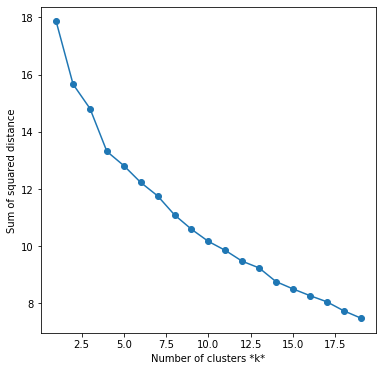

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.plot(range(1, 20), sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

We can see that 4 is a good choice from above plot.

In [12]:
k = 4
model = sklearn.cluster.KMeans(n_clusters=k, random_state=0).fit(clustering)
print(len(model.labels_))

103


Let's create a map of Toronto City.

In [13]:
import folium

toronto = folium.Map(location=[43.741667, -79.373333], zoom_start=10)
toronto

In [14]:
rgb_colors = ['red', 'blue', 'green', 'purple', 'orange']

In [15]:
df['Label'] = model.labels_
df.groupby('Label').count()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
Label,,,,,
0,3,3,3,3,3
1,12,12,12,12,12
2,2,2,2,2,2
3,86,86,86,86,86


Let's put the marker on the map, where different color indicate difference clusters.

In [18]:
for lat, lon, poi, cluster in zip(df['Latitude'], df['Longitude'], df['Postal Code'], df['Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rgb_colors[cluster],
        fill=True,
        fill_color=rgb_colors[cluster],
        fill_opacity=0.7).add_to(toronto)

toronto

We can see most of the Neighborhoods are label 3. Thus, most of Neighborhoods in Toronto City are similar.